<a href="https://colab.research.google.com/github/gustavoamora/ifood-data-analyst-case/blob/main/case_globo_DA_AED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas e configurações iniciais

In [ ]:
#Libs para manipulação:
import pandas as pd
import numpy as np
from collections import defaultdict

# Libs para gráficos:
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# Libs. para estatísticas / ml:
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from numpy.polynomial import Polynomial

# Configs de viz dos outputs do pandas:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Objetivo



*   Realizar uma análise exploratória dos dados com o objetivo de encontrar informações
úteis para identificação de perfis de usuários propensos a assinarem o Cartola. Utilize
técnicas de estatística e visualização de dados para apoiar suas conclusões.
*   Elaborar uma apresentação com a análise, resultados e sugestões de melhorias para o
projeto desenvolvido.
*   Disponibilizar o código fonte utilizado no exercício. Sua solução deve ser organizada,
legível e limpa, evitando soluções com over-engineering. Tente ser sucinto, mas preze pela
qualidade do código.

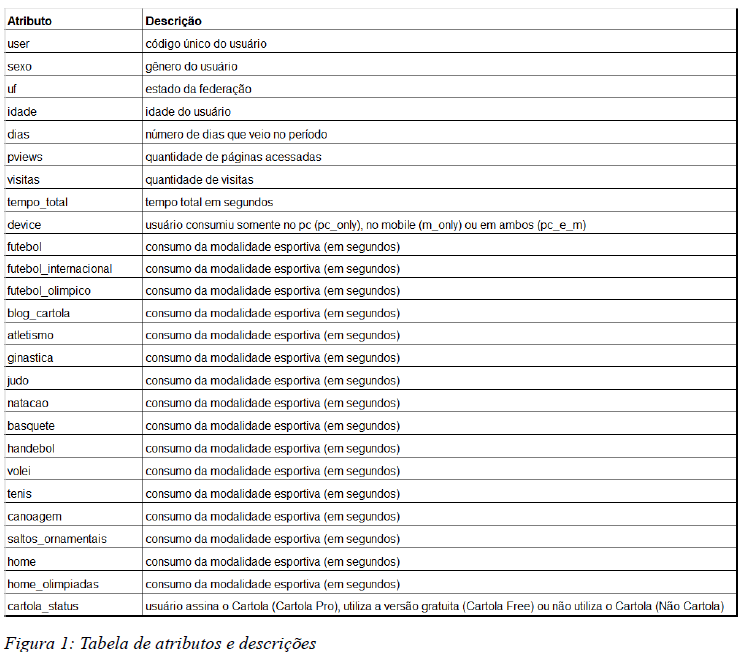

# Pre processamento

Scripts, data cleaning e tratamento de outliers

In [ ]:
# csv em df:

df = pd.read_csv('base_desafio_cartola.csv')
df.keys(), df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(Index(['user', 'sexo', 'uf', 'idade', 'dias', 'pviews', 'visitas', 'tempo_total', 'device', 'futebol', 'futebol_intenacional', 'futebol_olimpico', 'blog_cartola', 'atletismo', 'ginastica', 'judo', 'natacao', 'basquete', 'handebol', 'volei', 'tenis', 'canoagem', 'saltos_ornamentais', 'home', 'home_olimpiadas', 'cartola_status'], dtype='object'),
 (50689, 26))

## Scripts:

Diretório contendo as funções utilizadas ao longo da análise.
Subpastas indicando o uso das funções para facilitar a navegação.

As funções possuem uma explicação do seu objetivo, parâmetros necessários e saída

### Exploração dos dados

In [ ]:
# Função para visualizar por coluna: type, quant. de observações nulas, quant. de observações não nulas, quant. de valores distintos, distribuição das quantidades dos valores distintos

def column_summary(df):
    """
    Cria um sumário para um df

    Parâmetros:
    - data: DataFrame

    Retorna:
    - DataFrame com o nome das colunas do df, seu tipo, número de nulos, número de não nulos,
      quantidade de valores distintos e suas contagens
    """
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###  Limpeza

In [ ]:
# Função para imputar valores nulos proporcionalmente
def impute_proportional(data, column, proportions):
    """
    Imputa valores nulos em uma coluna com base na distribuição proporcional dos valores não nulos.

    Parâmetros:
    - data: DataFrame contendo a coluna a ser imputada.
    - column: string com o nome da coluna a ser imputada.
    - proportions: Series com a proporção de cada valor não nulo na coluna.

    Retorna:
    - DataFrame com os valores nulos imputados proporcionalmente.
    """
    # Gerar uma lista de valores a serem imputados proporcionalmente
    imputed_values = np.random.choice(proportions.index, size=data[column].isnull().sum(), p=proportions.values)

    # Imputar os valores nulos com os valores gerados
    data.loc[data[column].isnull(), column] = imputed_values


# Função para remover outliers de uma coluna
def remove_outliers(data, column):
    """
    Remove outliers de uma coluna com base no intervalo interquartil (IQR).

    Parâmetros:
    - data: DataFrame contendo a coluna a ser processada.
    - column: string com o nome da coluna a ser processada.

    Retorna:
    - DataFrame sem os outliers na coluna especificada.
    """
    # Calcula o primeiro e terceiro quartis
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificar outliers
    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)

    # Remover outliers
    data_cleaned = data[~outliers]

    return data_cleaned

# Função para remover outliers de várias colunas
def remove_outliers_mult(data, columns):
    """
    Remove outliers de múltiplas colunas em um DataFrame.

    Parâmetros:
    - data: DataFrame contendo as colunas a serem processadas.
    - columns: lista de strings com os nomes das colunas a serem processadas.

    Retorna:
    - DataFrame sem os outliers nas colunas especificadas.
    """
    for column in columns:
        data = remove_outliers(data, column)
    return data


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plots

In [ ]:
# Plotando as métricas de desempenho
def plot_model_metrics(metrics_df):
    metrics_df.set_index('Model', inplace=True)
    metrics_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.show()


# Função para plotar importância das features
def plot_feature_importance(df):
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    axes[0].barh(df['Feature'], df['imp_dtc'], color='r', alpha=0.6)
    axes[0].set_title('Decision Tree Feature Importance')

    axes[1].barh(df['Feature'], df['imp_rfc'], color='b', alpha=0.6)
    axes[1].set_title('Random Forest Feature Importance')

    axes[2].barh(df['Feature'], df['imp_xgb'], color='g', alpha=0.6)
    axes[2].set_title('XGBoost Feature Importance')

    for ax in axes:
        ax.set_xlabel('Importance')
        ax.set_ylabel('Feature')

    plt.tight_layout()
    plt.show()

# Função para coletar e plotar métricas de desempenho de modelos de machine learning
def collect_and_plot_metrics(models, X_train, X_test, y_train, y_test):
    """
    Coleta e plota as métricas de desempenho de vários modelos de machine learning.

    Parâmetros:
    - models: lista de tuplas contendo o nome do modelo e a instância do modelo.
    - X_train: DataFrame com as features de treino.
    - X_test: DataFrame com as features de teste.
    - y_train: Series ou array com os rótulos de treino.
    - y_test: Series ou array com os rótulos de teste.

    Retorna:
    - DataFrame com as métricas de desempenho dos modelos.
    """
    # Avaliando cada modelo individualmente e obtendo as métricas
    metrics_list = []
    for model_name, model in models:
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
        metrics_list.append(metrics)

    # Coletando todas as métricas em um DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    print(metrics_df)

    # Plotando as métricas de desempenho
    metrics_df.set_index('Model', inplace=True)
    metrics_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.show()

    return metrics_df


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### ML

In [ ]:
# Função para obter a importância das features ordenadas
def get_feature_importance(model, X_train):
    """
    Obtém e ordena a importância das features de um modelo de machine learning.

    Parâmetros:
    - model: modelo de machine learning a ser treinado.
    - X_train: DataFrame com as features de treino.

    Retorna:
    - DataFrame com as features e suas importâncias ordenadas.
    """
    # Verifica e obtém a importância das features
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    else:
        raise ValueError("O modelo não possui o atributo feature_importances_")

    # Cria um DataFrame com as importâncias
    feature_importances_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    })

    # Ordena as importâncias
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    feature_importances_df['Rank'] = feature_importances_df.index + 1

    return feature_importances_df

# Função para calcular e exibir métricas de desempenho de um modelo
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Treina um modelo e calcula suas métricas de desempenho.

    Parâmetros:
    - model: modelo de machine learning a ser treinado.
    - X_train: DataFrame com as features de treino.
    - X_test: DataFrame com as features de teste.
    - y_train: Series ou array com os rótulos de treino.
    - y_test: Series ou array com os rótulos de teste.
    - model_name: string com o nome do modelo para identificação.

    Retorna:
    - dicionário com as métricas de desempenho do modelo.
    """
    # Treina o modelo
    model.fit(X_train, y_train)
    # Realiza previsões
    y_pred = model.predict(X_test)
    # Calcula as métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Organiza as métricas em um dicionário
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    return metrics


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Exploração inicial

In [ ]:
# Exploração inicial

# Describe das das features
print(df.describe())

# Procurando por dados duplicados
print(df.duplicated().sum())
# Procurando por users duplicados
print(df['user'].duplicated().sum())

# Outuput do describe pede atenção para: 'idade';

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


               user         idade          dias        pviews       visitas    tempo_total        futebol  futebol_intenacional  futebol_olimpico   blog_cartola      atletismo      ginastica          judo        natacao       basquete       handebol         volei         tenis       canoagem  saltos_ornamentais           home  home_olimpiadas
count  5.068900e+04  22616.000000  50689.000000  50689.000000  50689.000000   50689.000000   50689.000000          50689.000000      50689.000000   50689.000000   50689.000000   50689.000000  50689.000000   50689.000000   50689.000000   50689.000000  50689.000000  50689.000000   50689.000000        50689.000000   50689.000000      50689.00000
mean   5.678938e+07     29.308719      8.538085     56.689459     17.148415   12637.405687    3937.687461            274.015518       1156.293316     822.864136     347.241928     312.669947    340.631099     297.421513     282.900358     251.781360    230.384103    138.543421     141.100257          114.6859

In [ ]:
# Viz da quantidade de observações por 'cartola_status'
data_for_plot = df.copy()
data_for_plot['cartola_status'] = data_for_plot['cartola_status'].fillna('Null')

# Preparar os dados para o gráfico
data_for_plot = data_for_plot.groupby(['cartola_status']).size().reset_index(name='contagem')

# Criar gráfico de barras
fig = px.bar(data_for_plot,
             x='cartola_status',
             y='contagem',
             color='cartola_status',
             title='Contagem de observações por cartola_status',
             labels={'cartola_status': 'cartola_status', 'contagem': 'Contagem'})

fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Data Cleaning

In [ ]:
# <<<<< Tratamento de valores nulos >>>>> #

data_cl = df.copy()

# -------------------------------------------------------------------------------------------------------------------------------------#
# >>> Tratando 'cartola_status' :
# >>> Sabemos que os valores 'Null' deveriam na verdade ser imputados como 'Não Cartola' devido a uma quebra no processo de ELT

# Preencher valores Null como 'Não Cartola'
data_cl['cartola_status'].fillna('Não Cartola', inplace=True)

# -------------------------------------------------------------------------------------------------------------------------------------#
# >>> Tratando 'idade' :
# >>> Para tratar os nulos da feature 'idade' vamos seguir com a mediana para contornar o efeito de outliers:

# Calcular a mediana da coluna 'idade'
idade_mediana = data_cl['idade'].median()
print(f"Mediana dos valores preenchidos em 'idade': {idade_mediana}")
# Substituir valores nulos na coluna 'idade' pela mediana
data_cl['idade'].fillna(idade_mediana, inplace=True)

# -------------------------------------------------------------------------------------------------------------------------------------#
# >>> Tratando 'uf' e 'sexo' :
# >>> Para uf e sexo vamos usar imputação probabilistica nos null

# Calcular as proporções de cada categoria em 'sexo'
sexo_proporcoes = data_cl['sexo'].value_counts(normalize=True)

# Calcular as proporções de cada categoria em 'uf'
uf_proporcoes = data_cl['uf'].value_counts(normalize=True)

# Chamar função para inpút proporcional
impute_proportional(data_cl, 'sexo', sexo_proporcoes)
impute_proportional(data_cl, 'uf', uf_proporcoes)

# -------------------------------------------------------------------------------------------------------------------------------------#

# Display dos dados nulos limpos :
summary_data = column_summary(data_cl)
display(summary_data)

Mediana dos valores preenchidos em 'idade': 27.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,user,int64,0,50689,50689,"{1912357: 1, 68162294: 1, 68163105: 1, 6816342..."
1,sexo,object,0,50689,2,"{'M': 45511, 'F': 5178}"
2,uf,object,0,50689,28,"{'Sao Paulo': 15573, 'Rio de Janeiro': 7846, '..."
3,idade,float64,0,50689,99,"{27.0: 29049, 26.0: 1159, 25.0: 1092, 22.0: 10..."
4,dias,int64,0,50689,31,"{1: 10211, 2: 5830, 3: 4075, 4: 3120, 5: 2648,..."
5,pviews,int64,0,50689,845,"{1: 5328, 2: 3917, 3: 2691, 4: 2177, 5: 1759, ..."
6,visitas,int64,0,50689,210,"{1: 9260, 2: 5142, 3: 3615, 4: 2773, 5: 2230, ..."
7,tempo_total,float64,0,50689,41665,"{45.0: 5330, 90.0: 1810, 135.0: 769, 180.0: 38..."
8,device,object,0,50689,3,"{'pc_only': 23929, 'm_only': 16053, 'pc_e_m': ..."
9,futebol,float64,0,50689,26714,"{0.0: 16576, 45.0: 4749, 90.0: 1527, 135.0: 54..."


In [ ]:
# Alterando o type da idade para inteiro

data_cl['idade'] = data_cl['idade'].astype(int)
data_cl['idade'].dtype

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



dtype('int64')

In [ ]:
# # <<<<< Tratamento dos outliers >>>>> #

# # Obter todas as colunas numéricas
# feat_out = data_cl.select_dtypes(include=['float64', 'int64']).columns
# # Retirar a feature idade pois foi inputada a mediana em grande parte do dataset.
# feat_out = feat_out.drop('idade')

# # Aplicar função de remoção dos outrliers (irá retornar um df com nome data_cleaned )
# data_teste = remove_outliers_mult(data_cl, feat_out)

# # Para idade: por conta do alto volume inputado como mediana, vamos tratar manualmente excluindo os menos que 16 e maiores que 100 arbitrariamente.
# # contagem < 16 e >100
# cont_menores = (data_teste['idade'] < 16).sum()
# cont_maiores = (data_teste['idade'] > 100).sum()
# print(f'''Número de observações com idade menor que 16: {cont_menores}
#           Número de observações com idade maiores que 100: {cont_maiores} ''')
# # Exclusão dos valores:
# data_teste = data_teste[(data_teste['idade'] > 16) & (data_teste['idade'] < 100)]

# display(df.describe()), display(data_teste.describe())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# <<<<< Tratamento dos outliers >>>>> #

# Para idade: por conta do alto volume inputado como mediana, vamos tratar manualmente excluindo os menos que 16 e maiores que 100 arbitrariamente.
# contagem < 16 e >100
cont_menores = (data_cl['idade'] < 16).sum()
cont_maiores = (data_cl['idade'] > 100).sum()
print(f'''Número de observações com idade menor que 16: {cont_menores}
          Número de observações com idade maiores que 100: {cont_maiores} ''')
# Exclusão dos valores:
data_cl_out = data_cl[(data_cl['idade'] > 16) & (data_cl['idade'] < 100)]

display(df.describe()), display(data_cl_out.describe())

Número de observações com idade menor que 16: 683
          Número de observações com idade maiores que 100: 23 


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,user,idade,dias,pviews,visitas,tempo_total,futebol,futebol_intenacional,futebol_olimpico,blog_cartola,atletismo,ginastica,judo,natacao,basquete,handebol,volei,tenis,canoagem,saltos_ornamentais,home,home_olimpiadas
count,5.068900e+04,22616.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.00000
mean,5.678938e+07,29.308719,8.538085,56.689459,17.148415,12637.405687,3937.687461,274.015518,1156.293316,822.864136,347.241928,312.669947,340.631099,297.421513,282.900358,251.781360,230.384103,138.543421,141.100257,114.685967,1931.810051,650.79972
std,1.608739e+07,49.140567,8.201193,109.424394,24.828745,27908.554735,11090.160922,2155.114900,4146.357108,4251.866684,2025.333697,2097.682553,2370.173172,2275.266761,1862.177775,1693.323186,1528.322303,1090.553805,1256.204387,1040.395728,7109.661917,3009.07565
min,1.912357e+06,-7161.000000,1.000000,1.000000,1.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,4.527815e+07,22.000000,2.000000,4.000000,2.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5.935156e+07,27.000000,5.000000,15.000000,7.000000,1671.576000,135.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.565000,0.00000
75%,7.042032e+07,35.000000,13.000000,58.000000,21.000000,10349.220999,2366.065000,0.000000,209.871000,199.010000,8.068000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,569.675000,129.13200
max,5.000061e+08,236.000000,31.000000,2143.000000,277.000000,225690.794000,187225.147000,161337.180000,176608.438000,196982.898000,104413.659000,144959.699000,94089.566000,170804.685000,115990.668000,104274.176000,90985.219000,84894.916000,106953.499000,84184.831000,192745.565000,101053.63500


,user,idade,dias,pviews,visitas,tempo_total,futebol,futebol_intenacional,futebol_olimpico,blog_cartola,atletismo,ginastica,judo,natacao,basquete,handebol,volei,tenis,canoagem,saltos_ornamentais,home,home_olimpiadas
count,4.956600e+04,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000
mean,5.691564e+07,28.446011,8.547855,56.814429,17.178247,12724.458520,3949.347012,275.571306,1171.118238,819.613266,351.470108,316.979289,345.568598,302.399253,287.104044,256.010163,233.989142,139.533196,143.652027,116.569978,1935.609026,659.217079
std,1.618386e+07,7.145507,8.203632,109.559874,24.856948,28034.554808,11119.944299,2175.092748,4177.589662,4269.970357,2032.698106,2117.131378,2391.280781,2298.774207,1880.373951,1710.073049,1543.754930,1095.160200,1269.370965,1051.335771,7125.205403,3034.455716
min,1.912357e+06,17.000000,1.000000,1.000000,1.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.539268e+07,27.000000,2.000000,4.000000,2.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.964219e+07,27.000000,5.000000,15.000000,7.000000,1695.090500,135.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.685500,0.000000
75%,7.057631e+07,27.000000,13.000000,58.000000,22.000000,10480.000750,2373.141250,0.000000,218.703750,192.358750,20.101250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,571.426250,135.000000
max,5.000061e+08,96.000000,31.000000,2143.000000,277.000000,225690.794000,187225.147000,161337.180000,176608.438000,196982.898000,104413.659000,144959.699000,94089.566000,170804.685000,115990.668000,104274.176000,90985.219000,84894.916000,106953.499000,84184.831000,192745.565000,101053.635000


(None, None)

# Estatítica descritiva
Resumo das estatísticas descritivas das variáveis numéricas e frequência e proporção das variáveis categóricas

In [ ]:
data = data_cl_out.copy()

# Estatísticas descritivas para variáveis numéricas
numeric_stats = data.describe()

# Estatísticas descritivas para variáveis categóricas
categorical_stats = data.describe(include=['object'])

display(numeric_stats), display(categorical_stats)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,user,idade,dias,pviews,visitas,tempo_total,futebol,futebol_intenacional,futebol_olimpico,blog_cartola,atletismo,ginastica,judo,natacao,basquete,handebol,volei,tenis,canoagem,saltos_ornamentais,home,home_olimpiadas
count,4.956600e+04,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000,49566.000000
mean,5.691564e+07,28.446011,8.547855,56.814429,17.178247,12724.458520,3949.347012,275.571306,1171.118238,819.613266,351.470108,316.979289,345.568598,302.399253,287.104044,256.010163,233.989142,139.533196,143.652027,116.569978,1935.609026,659.217079
std,1.618386e+07,7.145507,8.203632,109.559874,24.856948,28034.554808,11119.944299,2175.092748,4177.589662,4269.970357,2032.698106,2117.131378,2391.280781,2298.774207,1880.373951,1710.073049,1543.754930,1095.160200,1269.370965,1051.335771,7125.205403,3034.455716
min,1.912357e+06,17.000000,1.000000,1.000000,1.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.539268e+07,27.000000,2.000000,4.000000,2.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.964219e+07,27.000000,5.000000,15.000000,7.000000,1695.090500,135.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.685500,0.000000
75%,7.057631e+07,27.000000,13.000000,58.000000,22.000000,10480.000750,2373.141250,0.000000,218.703750,192.358750,20.101250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,571.426250,135.000000
max,5.000061e+08,96.000000,31.000000,2143.000000,277.000000,225690.794000,187225.147000,161337.180000,176608.438000,196982.898000,104413.659000,144959.699000,94089.566000,170804.685000,115990.668000,104274.176000,90985.219000,84894.916000,106953.499000,84184.831000,192745.565000,101053.635000


,sexo,uf,device,cartola_status
count,49566,49566,49566,49566
unique,2,28,3,3
top,M,Sao Paulo,pc_only,Cartola Free
freq,44470,15243,23517,28058


(None, None)

## Boxplots

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



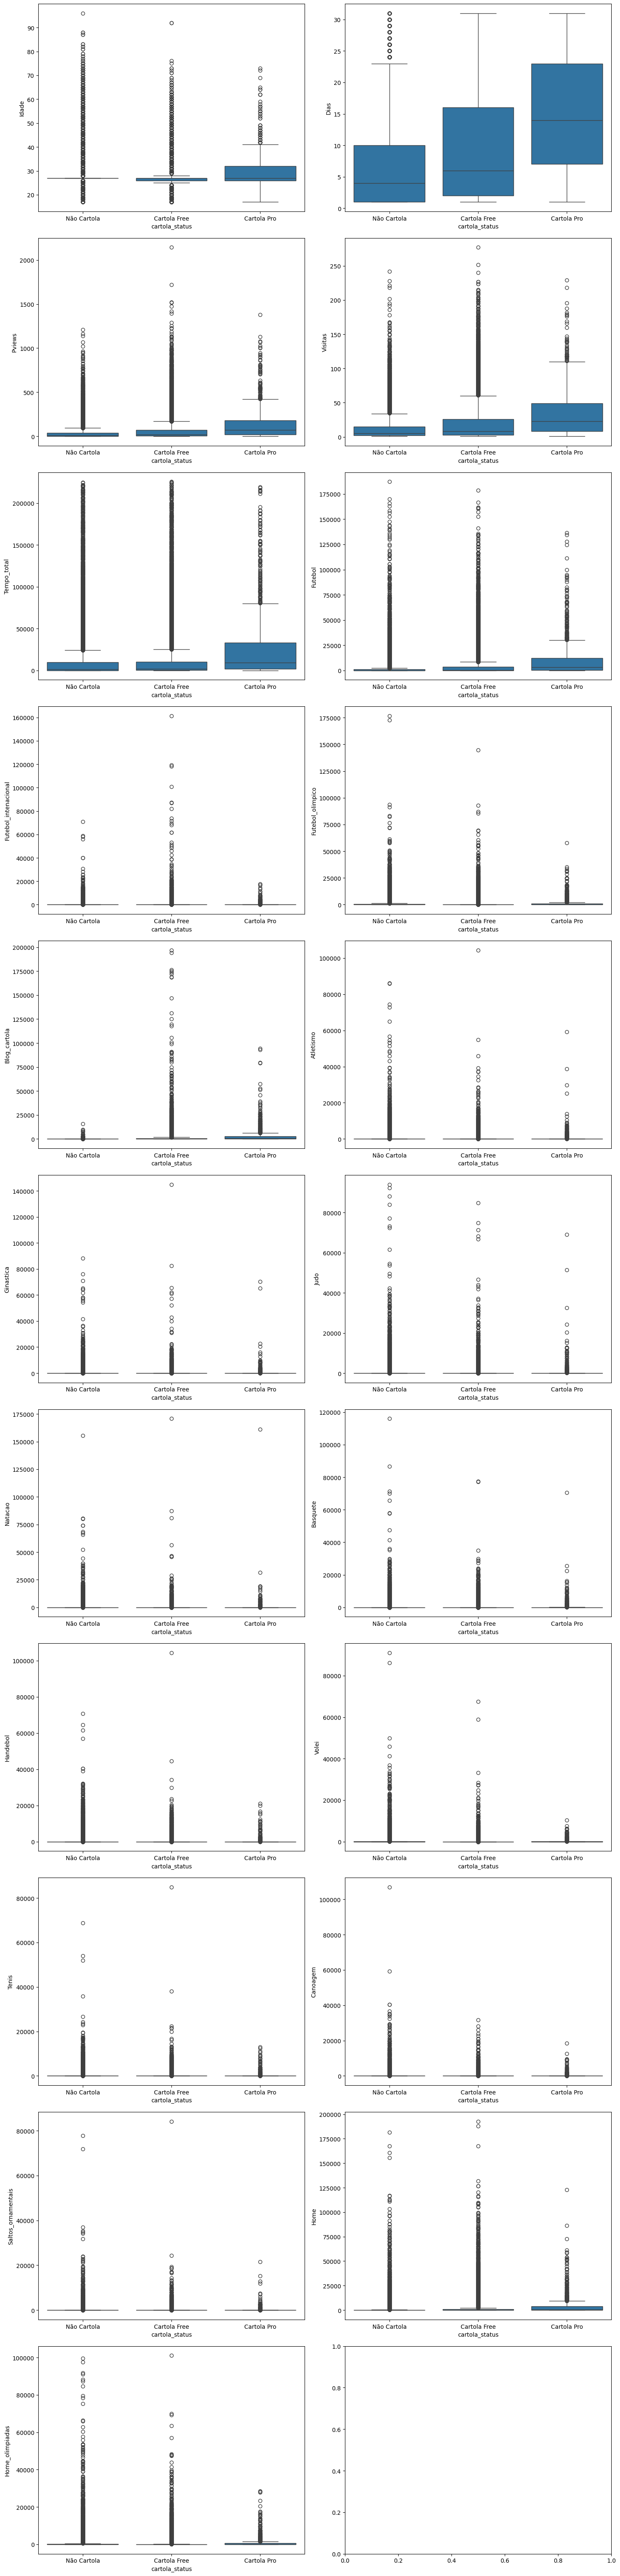

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Variáveis para os boxplots
numerical_cols = ['idade', 'dias', 'pviews', 'visitas', 'tempo_total', 'futebol',
                  'futebol_intenacional', 'futebol_olimpico', 'blog_cartola', 'atletismo',
                  'ginastica', 'judo', 'natacao', 'basquete',
                  'handebol', 'volei', 'tenis', 'canoagem',
                  'saltos_ornamentais', 'home', 'home_olimpiadas']
categorical_cols = ['sexo', 'uf', 'device']
dependent_col = ['cartola_status']


# Criar subplots
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(15, 62))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotar cada boxplot
for i, var in enumerate(numerical_cols):
    sns.boxplot(x="cartola_status", y=var, data=data, ax=axes[i])
    axes[i].set_ylabel(var.capitalize())

# Ajustar o layout
plt.tight_layout()
plt.show()


## Tabela
Por cartola status

In [ ]:
# Calcular as estatísticas descritivas para cada variável numérica agrupada por cartola_status
summary_stats = data.groupby(dependent_col)[numerical_cols].describe()

display(summary_stats)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



idade                                                        dias                                                    pviews                                                            visitas                                                    tempo_total                                                                                     futebol                                                                                    futebol_intenacional                                                                 futebol_olimpico                                                                  blog_cartola                                                                             atletismo                                                              ginastica                                                               judo                                                              natacao                                                           basquete  \
                  count       mean       std   min   25%   50%   75%   max    count       mean       std  min  25%   50%   75%   max    count        mean         std  min    25%   50%     75%     max    count       mean        std  min  25%   50%   75%    max       count          mean           std   min         25%        50%           75%         max    count          mean           std  min        25%        50%          75%            max                count        mean          std  min  25%  50%      75%            max            count         mean          std  min  25%   50%        75%         max        count         mean          std  min     25%       50%         75%            max     count        mean          std  min  25%  50%      75%         max     count        mean          std  min  25%  50%   75%         max    count        mean          std  min  25%  50%   75%           max    count        mean          std  min  25%  50%   75%         max    count   
cartola_status                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
Cartola Free    28058.0  27.430608  5.894576  17.0  26.0  27.0  27.0  92.0  28058.0   9.779885  8.782199  1.0  2.0   6.0  16.0  31.0  28058.0   66.529795  121.544185  1.0   5.00  18.0   71.00  2143.0  28058.0  20.121997  27.529275  1.0  3.0   8.0  26.0  277.0     28058.0  12444.140114  27220.623043  45.0   225.50425  1767.8455  10333.269750  225690.794  28058.0   4614.070368  11703.355227  0.0    0.00000   265.4565   3450.50475  178642.596001              28058.0  336.962958  2587.726425  0.0  0.0  0.0   4.0830  161337.180000          28058.0   865.438334  3465.236672  0.0  0.0   0.0  123.49375  144780.574      28058.0  1316.611807  5357.906653  0.0  45.000  108.7000   757.50675  196982.898000   28058.0  217.514338  1432.714811  0.0  0.0  0.0   0.0000  104413.659   28058.0  182.656185  1660.306069  0.0  0.0  0.0   0.0  144959.699  28058.0  211.288730  1761.282823  0.0  0.0  0.0   0.0  84762.312001  28058.0  178.914151  1714.437702  0.0  0.0  0.0   0.0  170804.685  28058.0   
Cartola Pro      1074.0  29.526071  7.647388  17.0  26.0  

## Correlação

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



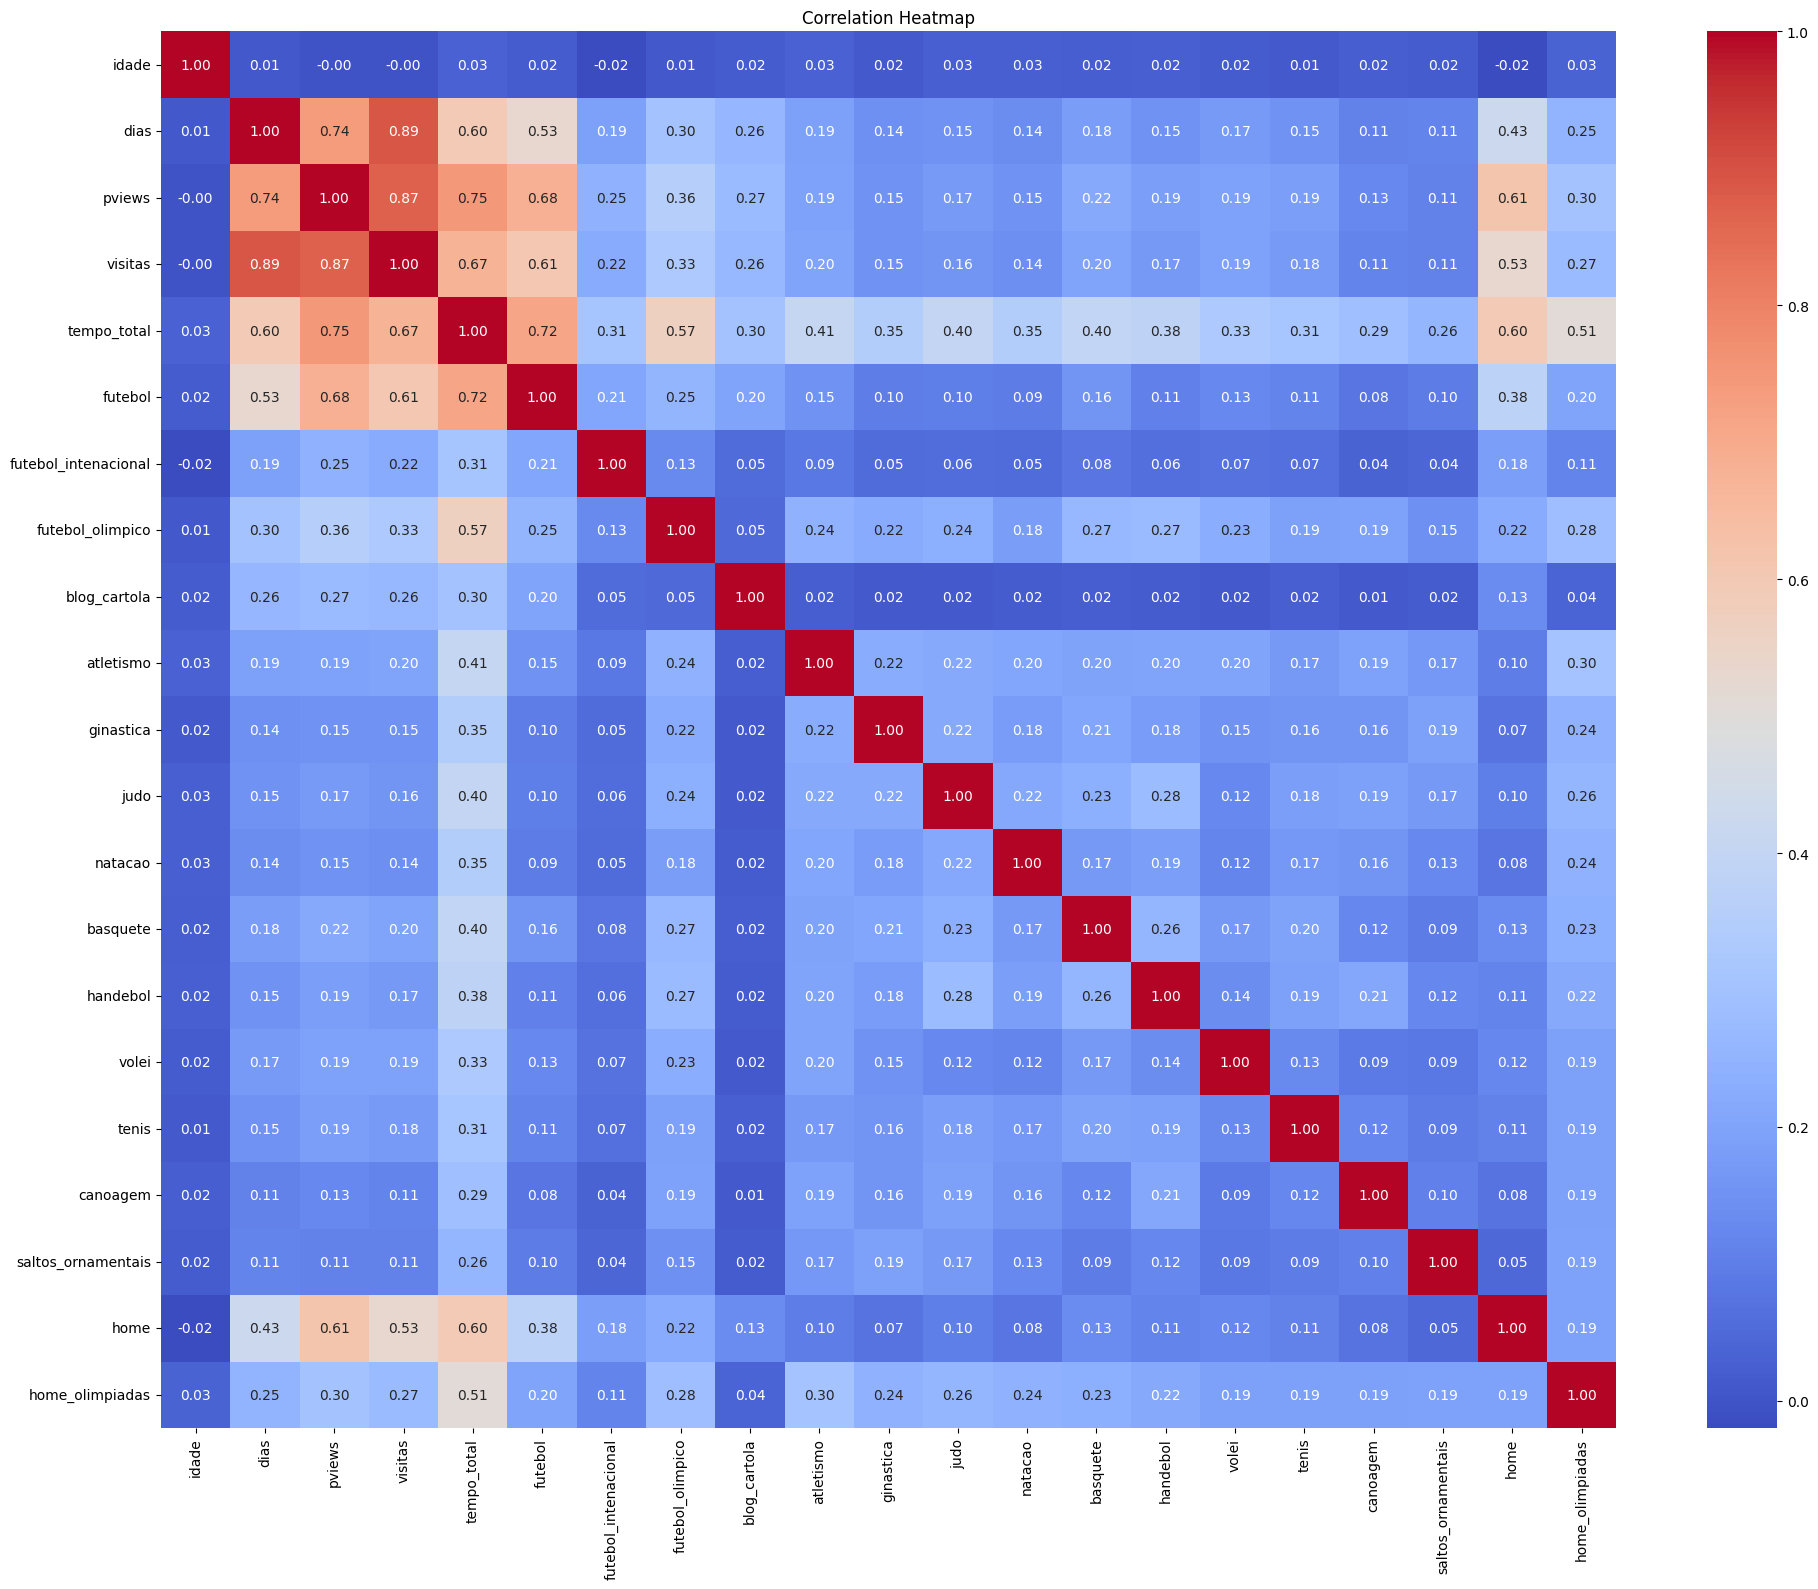

Maximum pairwise correlation: 0.89


In [ ]:
# Matriz de Correlação

correlation_matrix = data[numerical_cols].corr()

# Create the heatmap
plt.figure(figsize=(20, 16))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set title
plt.title('Correlation Heatmap')

# Show the plot
plt.tight_layout()
plt.show()

# Find the max correlation
upper_triangular = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
max_correlation = upper_triangular.max().max()
print(f"Maximum pairwise correlation: {max_correlation:.2f}")

## Viz features categóricas

In [ ]:
# Grafico stack por features categoricas (device, uf, sexo)

# Agregando os dados para obter a contagem de usuários em cada combinação de "cartola_status" e "uf"
agg_df_uf = data.groupby(['cartola_status', 'uf']).size().reset_index(name='count')
agg_df_sexo = data.groupby(['cartola_status', 'sexo']).size().reset_index(name='count')
agg_df_device = data.groupby(['cartola_status', 'device']).size().reset_index(name='count')

# Criando o gráfico de barras stack uf
fig_1 = px.bar(agg_df_uf, x="cartola_status", y="count", color="uf",
             title="Contagem de usuários por cartola_status e cores por contagem de uf",
             category_orders={"cartola_status": ["Ativo", "Inativo"]})

# Criando o gráfico de barras stack Sexo
fig_2 = px.bar(agg_df_sexo, x="cartola_status", y="count", color="sexo",
             title="Contagem de usuários por cartola_status e cores por contagem de uf",
             category_orders={"cartola_status": ["Ativo", "Inativo"]})

# Criando o gráfico de barras stack Device
fig_3 = px.bar(agg_df_device, x="cartola_status", y="count", color="device",
             title="Contagem de usuários por cartola_status e cores por contagem de uf",
             category_orders={"cartola_status": ["Ativo", "Inativo"]})

fig_1.show(), fig_2.show(), fig_3.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(None, None, None)

# Cartola Free -> Cartola PRO

Busca de padrões para potencial migração de Cartola Free para Cartola Pro

## Teste de hipóteses

H0 = não existe relação entre as features e o cartola_status

#### T-Student:

O teste t de Student é usado para comparar as médias de duas amostras e determinar se elas são significativamente diferentes uma da outra.

statistic:
O valor do t-statístico. Um valor alto (positivo ou negativo) indica uma grande diferença entre as médias.

pvalue: O valor p associado ao teste t. Um valor p pequeno (geralmente < 0.05) indica que a diferença entre as médias é estatisticamente significativa.

df: Os graus de liberdade do teste.


In [ ]:
# Teste t de Student para variáveis numéricas (Cartola Pro vs Cartola Free)

from scipy.stats import ttest_ind

# Filtrar dados para cada grupo
pro_group = data[data['cartola_status'] == 'Cartola Pro']
non_pro_group = data[data['cartola_status'] == 'Cartola Free']

# Realizar teste t para variáveis numéricas
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
t_test_results = {col: ttest_ind(pro_group[col], non_pro_group[col], nan_policy='omit') for col in numeric_cols}

import scipy.stats as stats

# Definir o nível de significância (5%)
alpha = 0.05

# Calcular o valor crítico para um teste bicaudal
df = 29130.0  # Graus de liberdade
t_critical = round(stats.t.ppf(1 - alpha/2, df),2)

print(f"Valor crítico para df = {df} e alpha = {alpha}: {t_critical}")


display(t_test_results)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Valor crítico para df = 29130.0 e alpha = 0.05: 1.96


{'user': TtestResult(statistic=-20.487154161562344, pvalue=1.262147788985254e-92, df=29130.0),
 'idade': TtestResult(statistic=11.29213650647219, pvalue=1.6528708530265508e-29, df=29130.0),
 'dias': TtestResult(statistic=18.556759358650492, pvalue=1.9855380282561497e-76, df=29130.0),
 'pviews': TtestResult(statistic=18.765754041104838, pvalue=4.1621357816908357e-78, df=29130.0),
 'visitas': TtestResult(statistic=17.087943266370246, pvalue=3.794059437986881e-65, df=29130.0),
 'tempo_total': TtestResult(statistic=17.036337622089402, pvalue=9.09933258294878e-65, df=29130.0),
 'futebol': TtestResult(statistic=15.729254581601584, pvalue=1.6140302615554797e-55, df=29130.0),
 'futebol_intenacional': TtestResult(statistic=1.0529860644656575, pvalue=0.2923561131668926, df=29130.0),
 'futebol_olimpico': TtestResult(statistic=7.329691303883196, pvalue=2.3667806852052544e-13, df=29130.0),
 'blog_cartola': TtestResult(statistic=11.077337383679197, pvalue=1.84218753849098e-28, df=29130.0),
 'atletis

Todos os valores maiores que 1.96 e pvalue menor que 0.05
são considerados com diferenças significativas.

### Chi square

O teste chi-square é usado para testar a independência entre duas variáveis categóricas.

statistic: O valor do qui-quadrado. Valores maiores indicam maior associação entre as variáveis.
pvalue: O valor p associado ao teste qui-quadrado. Um valor p pequeno (geralmente < 0.05) indica que há uma associação significativa entre as variáveis.
dof: Os graus de liberdade do teste.
expected_freq: As frequências esperadas se as variáveis fossem independentes.

Resumo:
Teste Qui-Quadrado: Para as variáveis com p-values < 0.05, há uma associação significativa entre as variáveis categóricas e a variável de interesse.

In [ ]:
# Teste chi quadrado apenas para buscar padrões de diferença entre Cartola Free e Cartola Pro

from scipy.stats import chi2_contingency

# Filtrar dados para incluir apenas Cartola Free e Cartola Pro
data_filtered = data[data['cartola_status'].isin(['Cartola Free', 'Cartola Pro'])]

# Realizar teste qui-quadrado para variáveis categóricas
categorical_cols = data_filtered.select_dtypes(include=['object']).columns
chi2_results = {}
for col in categorical_cols:
    if col != 'cartola_status':
        contingency_table = pd.crosstab(data_filtered[col], data_filtered['cartola_status'])
        chi2_results[col] = chi2_contingency(contingency_table)

# Exibir os resultados
for col, result in chi2_results.items():
    print(f"Variável: {col}")
    print(f"Chi2-statistic: {result[0]}, p-value: {result[1]}, Degrees of Freedom: {result[2]}")
    print()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Variável: sexo
Chi2-statistic: 7.577127773432755, p-value: 0.005911355791531804, Degrees of Freedom: 1

Variável: uf
Chi2-statistic: 42.54087002824858, p-value: 0.029088923767334067, Degrees of Freedom: 27

Variável: device
Chi2-statistic: 331.79291012630154, p-value: 8.955400207013914e-73, Degrees of Freedom: 2



### Resultados

In [ ]:
# Converter os resultados do teste t em um DataFrame
t_test_df = pd.DataFrame({
    'Variable': t_test_results.keys(),
    't-statistic': [result.statistic for result in t_test_results.values()],
    'p-value': [result.pvalue for result in t_test_results.values()],
    'Degrees of Freedom': [result.df for result in t_test_results.values()]
})

# Converter os resultados do teste qui-quadrado em um DataFrame
chi2_test_df = pd.DataFrame({
    'Variable': chi2_results.keys(),
    'Chi2-statistic': [result[0] for result in chi2_results.values()],
    'p-value': [result[1] for result in chi2_results.values()],
    'Degrees of Freedom': [result[2] for result in chi2_results.values()]
})

display(t_test_df), display(chi2_test_df),

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Variable,t-statistic,p-value,Degrees of Freedom
0,user,-20.487154,1.262148e-92,29130.0
1,idade,11.292137,1.652871e-29,29130.0
2,dias,18.556759,1.985538e-76,29130.0
3,pviews,18.765754,4.162136e-78,29130.0
4,visitas,17.087943,3.794059e-65,29130.0
5,tempo_total,17.036338,9.099333e-65,29130.0
6,futebol,15.729255,1.614030e-55,29130.0
7,futebol_intenacional,1.052986,2.923561e-01,29130.0
8,futebol_olimpico,7.329691,2.366781e-13,29130.0
9,blog_cartola,11.077337,1.842188e-28,29130.0


,Variable,Chi2-statistic,p-value,Degrees of Freedom
0,sexo,7.577128,5.911356e-03,1
1,uf,42.540870,2.908892e-02,27
2,device,331.792910,8.955400e-73,2


(None, None)

### Conclusão



*  T-Student:
Com exceção de futebol_internacional, todos as outras features numéricas apresentam diferença com relevência estatística significativa entre os grupos 'Cartola Pro' e 'Cartola Free'.

*  Qui-quadrado:
Há uma associação estatisticamente significativa entre "device" e "sexo" e a variável dependente 'cartola_status'

## Feature Importance

In [ ]:
data_ml = data_cl_out.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-22-aa5be3eae212>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Model  Accuracy  Precision    Recall  F1 Score
0  Decision Tree  0.930324   0.935285  0.930324  0.932771
1  Random Forest  0.962760   0.927555  0.962760  0.944829
2        XGBoost  0.962245   0.927536  0.962245  0.944572


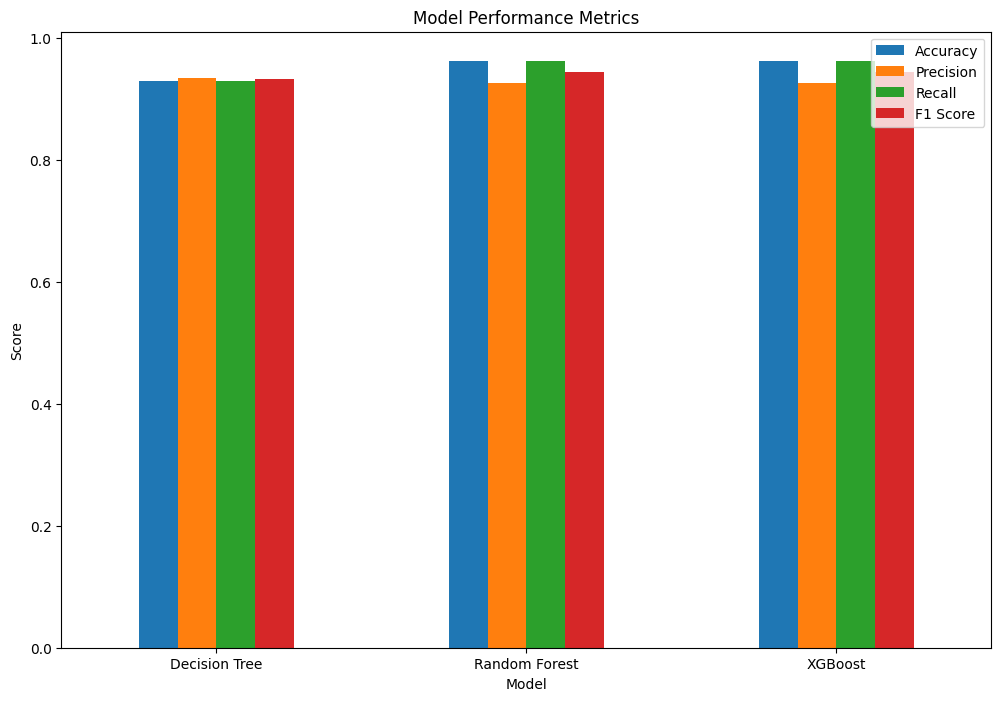

,Feature,imp_dtc,rank_dtc,imp_rfc,rank_rfc,imp_xgb,rank_xgb
0,tempo_total,0.098068,1,0.097303,1,0.021796,15
1,blog_cartola,0.095778,2,0.086703,2,0.025450,5
2,futebol,0.080148,3,0.075658,3,0.024307,9
3,pviews,0.078546,4,0.071902,4,0.038124,2
4,home,0.068551,5,0.062165,6,0.021727,16
5,idade,0.054865,6,0.070440,5,0.029016,3
6,visitas,0.054005,7,0.056314,7,0.021524,17
7,dias,0.044809,8,0.048208,8,0.028969,4
8,futebol_olimpico,0.038301,9,0.040455,9,0.020920,22
9,home_olimpiadas,0.037441,10,0.040082,10,0.021063,18


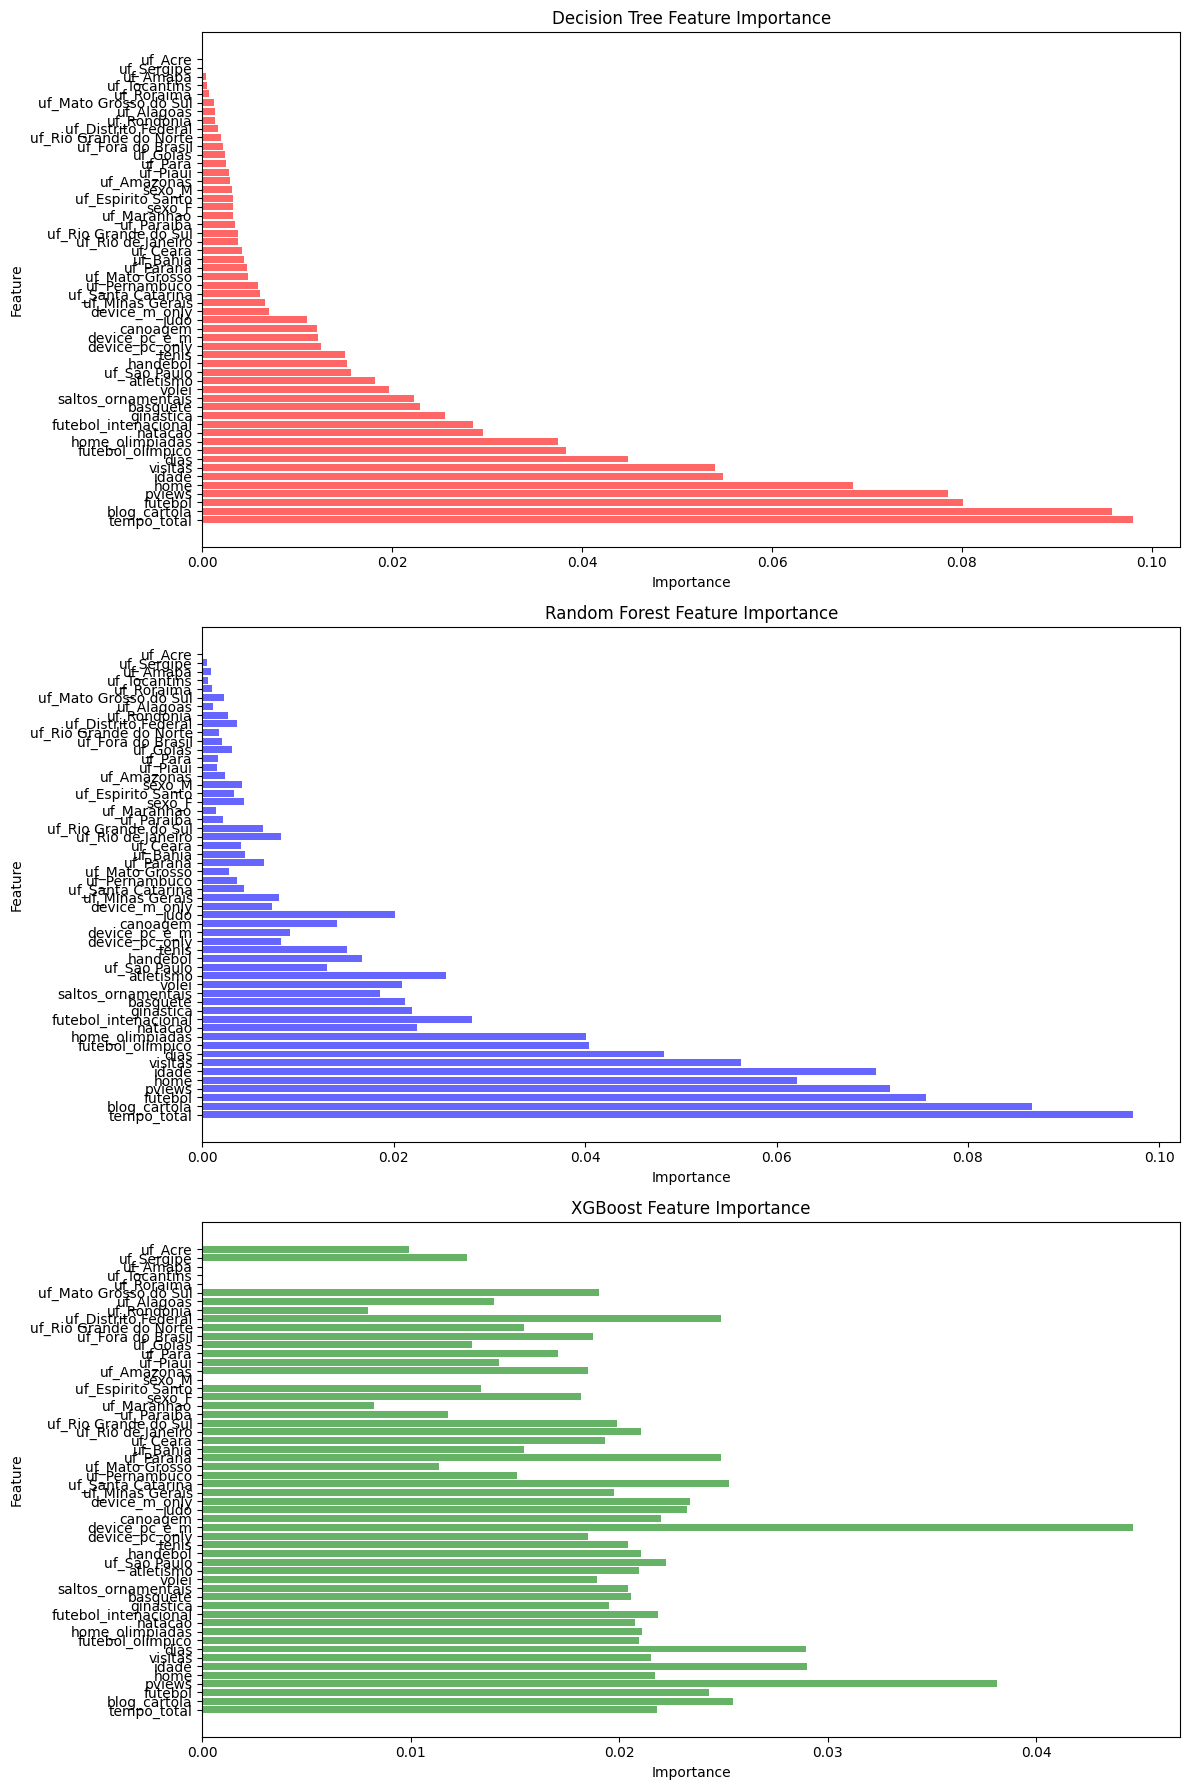

In [ ]:
# Importações necessárias
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Definir a seed para reprodutibilidade
seed = 42
np.random.seed(seed)

# Configurações básicas
df_l2 = data_ml.copy()

# Passo 1 e 2: Filtrar o DataFrame para excluir "Não Cartola" e transformar o problema em binário
df_filtered = df_l2[df_l2['cartola_status'].isin(['Cartola Free', 'Cartola Pro'])]
df_filtered['is_cartola_pro'] = df_filtered['cartola_status'].apply(lambda x: 1 if x == 'Cartola Pro' else 0)

# Definindo X, y e tipos de colunas
numerical_cols = ['idade', 'dias', 'pviews', 'visitas', 'tempo_total', 'futebol',
                  'futebol_intenacional', 'futebol_olimpico', 'blog_cartola', 'atletismo',
                  'ginastica', 'judo', 'natacao', 'basquete',
                  'handebol', 'volei', 'tenis', 'canoagem',
                  'saltos_ornamentais', 'home', 'home_olimpiadas']
categorical_cols = ['sexo', 'uf', 'device']
dependent_col = ['is_cartola_pro']
independent_col = numerical_cols + categorical_cols
all_cols = numerical_cols + categorical_cols + dependent_col

# Passo 3: Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_filtered[independent_col], df_filtered[dependent_col],
                                                    stratify=df_filtered[dependent_col], test_size=0.2, random_state=seed)

# Pré-processador para colunas numéricas e categóricas
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_cols),
                                               ('cat', OneHotEncoder(), categorical_cols)])

# Transformar os dados
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Converter os dados transformados de volta para DataFrame
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Inicializando e treinando os modelos
dt_model = DecisionTreeClassifier(random_state=seed)
rf_model = RandomForestClassifier(random_state=seed)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed)

dt_model.fit(X_train_transformed_df, y_train.values.ravel())
rf_model.fit(X_train_transformed_df, y_train.values.ravel())
xgb_model.fit(X_train_transformed_df, y_train.values.ravel())

# Avaliando cada modelo individualmente e obtendo as métricas
dt_metrics = evaluate_model(dt_model, X_train_transformed_df, X_test_transformed_df, y_train.values.ravel(), y_test.values.ravel(), "Decision Tree")
rf_metrics = evaluate_model(rf_model, X_train_transformed_df, X_test_transformed_df, y_train.values.ravel(), y_test.values.ravel(), "Random Forest")
xgb_metrics = evaluate_model(xgb_model, X_train_transformed_df, X_test_transformed_df, y_train.values.ravel(), y_test.values.ravel(), "XGBoost")

# Coletando todas as métricas em um DataFrame
metrics_df = pd.DataFrame([dt_metrics, rf_metrics, xgb_metrics])
print(metrics_df)

# Gráfico com as métricas
plot_model_metrics(metrics_df)

# Obter importâncias das features dos modelos já treinados
dt_fi = get_feature_importance(dt_model, X_train_transformed_df)
rf_fi = get_feature_importance(rf_model, X_train_transformed_df)
xgb_fi = get_feature_importance(xgb_model, X_train_transformed_df)

# Renomear as colunas para mesclagem
dt_fi = dt_fi.rename(columns={'Importance': 'imp_dtc', 'Rank': 'rank_dtc'})
rf_fi = rf_fi.rename(columns={'Importance': 'imp_rfc', 'Rank': 'rank_rfc'})
xgb_fi = xgb_fi.rename(columns={'Importance': 'imp_xgb', 'Rank': 'rank_xgb'})

# Mesclar os DataFrames de importância das features
merged_df = dt_fi.merge(rf_fi, on='Feature', how='left')\
                 .merge(xgb_fi, on='Feature', how='left')

display(merged_df)

# Plotando a importância das features
plot_feature_importance(merged_df)

## Valores de referência

Calcular os valores de referência para selecionar os usuários do grupo Cartola Free que tenham comportamentos semelhantes ao Cartola Pro nas features de interesse.

In [ ]:
# Calculando Q1 (primeiro quartil) para Cartola Pro

cartola_pro = data[data['cartola_status'] == 'Cartola Pro']
cortes = ['tempo_total', 'blog_cartola', 'futebol', 'pviews', 'idade']
cartola_pro_cortes = cartola_pro[cortes]

q1_pro = cartola_pro_cortes.quantile(0.25)

print(q1_pro)

tempo_total     1665.10600
blog_cartola      49.07500
futebol          220.28925
pviews            19.25000
idade             26.00000
Name: 0.25, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Aplicar o corte nos dados do Cartola Free

cartola_free = data[data['cartola_status'] == 'Cartola Free']

cont_base_free = cartola_free[
    (cartola_free['tempo_total'] >= q1_pro['tempo_total']) &
    (cartola_free['blog_cartola'] >= q1_pro['blog_cartola']) &
    (cartola_free['futebol'] >= q1_pro['futebol']) &
    (cartola_free['pviews'] >= q1_pro['pviews']) &
    (cartola_free['idade'] >= q1_pro['idade'])
]

tot_base_free = cartola_free.shape[0]
tot_base_free_corte = cont_base_free.shape[0]
perc_free = (tot_base_free_corte / tot_base_free)*100

print(f'''Percentual da base de Cartola Free selecionado: {round(perc_free,2)}
      Amostra Cartola Free: {tot_base_free}
      User Selecionados: {tot_base_free_corte}
      ''')

Percentual da base de Cartola Free selecionado: 21.87
      Amostra Cartola Free: 28058
      User Selecionados: 6137
      


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# Não Cartola -> Cartola Free

Busca de padrões para potencial migração de Não Cartola para Cartola Free

## Teste de hipóteses:

### T-Student


In [ ]:
# Teste t de Student para variáveis numéricas (Cartola Free vs Não Cartola)

from scipy.stats import ttest_ind

# Filtrar dados para cada grupo
f_cartola = data[data['cartola_status'] == 'Cartola Free']
n_cartola = data[data['cartola_status'] == 'Não Cartola']

# Realizar teste t para variáveis numéricas
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
t_test_results = {col: ttest_ind(f_cartola[col], n_cartola[col], nan_policy='omit') for col in numeric_cols}

import scipy.stats as stats

# Definir o nível de significância (5%)
alpha = 0.05

# Calcular o valor crítico para um teste bicaudal
df = 29130.0  # Graus de liberdade
t_critical = round(stats.t.ppf(1 - alpha/2, df),2)

print(f"Valor crítico para df = {df} e alpha = {alpha}: {t_critical}")


display(t_test_results)

Valor crítico para df = 29130.0 e alpha = 0.05: 1.96


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'user': TtestResult(statistic=-10.788472147065926, pvalue=4.189049636641372e-27, df=48490.0),
 'idade': TtestResult(statistic=-36.35650712486721, pvalue=1.461992943029594e-285, df=48490.0),
 'dias': TtestResult(statistic=44.4464473756113, pvalue=0.0, df=48490.0),
 'pviews': TtestResult(statistic=28.14690436088286, pvalue=6.474765096167443e-173, df=48490.0),
 'visitas': TtestResult(statistic=35.70459440130349, pvalue=1.2812216883348838e-275, df=48490.0),
 'tempo_total': TtestResult(statistic=0.3767654925797333, pvalue=0.7063495356918301, df=48490.0),
 'futebol': TtestResult(statistic=19.27563069221389, pvalue=1.7535454546752632e-82, df=48490.0),
 'futebol_intenacional': TtestResult(statistic=7.628426939335378, pvalue=2.4196143046598046e-14, df=48490.0),
 'futebol_olimpico': TtestResult(statistic=-18.30212430573531, pvalue=1.4203764246014515e-74, df=48490.0),
 'blog_cartola': TtestResult(statistic=34.793107954441176, pvalue=5.287890279765585e-262, df=48490.0),
 'atletismo': TtestResult(

### Chi Square

In [ ]:
# Teste chi quadrado apenas para buscar padrões de diferença entre Cartola Free e Cartola Pro

from scipy.stats import chi2_contingency
import pandas as pd

# Filtrar dados para incluir apenas Cartola Free e Cartola Pro
data_filtered = data[data['cartola_status'].isin(['Cartola Free', 'Não Cartola'])]

# Realizar teste qui-quadrado para variáveis categóricas
categorical_cols = data_filtered.select_dtypes(include=['object']).columns
chi2_results = {}
for col in categorical_cols:
    if col != 'cartola_status':
        contingency_table = pd.crosstab(data_filtered[col], data_filtered['cartola_status'])
        chi2_results[col] = chi2_contingency(contingency_table)

# Exibir os resultados
for col, result in chi2_results.items():
    print(f"Variável: {col}")
    print(f"Chi2-statistic: {result[0]}, p-value: {result[1]}, Degrees of Freedom: {result[2]}")
    print()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Variável: sexo
Chi2-statistic: 595.3975535731854, p-value: 1.6783175235872662e-131, Degrees of Freedom: 1

Variável: uf
Chi2-statistic: 103.32749261943202, p-value: 7.267738424926549e-11, Degrees of Freedom: 27

Variável: device
Chi2-statistic: 4774.056212298749, p-value: 0.0, Degrees of Freedom: 2



### Resultados

In [ ]:
# Converter os resultados do teste t em um DataFrame
t_test_df = pd.DataFrame({
    'Variable': t_test_results.keys(),
    't-statistic': [result.statistic for result in t_test_results.values()],
    'p-value': [result.pvalue for result in t_test_results.values()],
    'Degrees of Freedom': [result.df for result in t_test_results.values()]
})

# Converter os resultados do teste qui-quadrado em um DataFrame
chi2_test_df = pd.DataFrame({
    'Variable': chi2_results.keys(),
    'Chi2-statistic': [result[0] for result in chi2_results.values()],
    'p-value': [result[1] for result in chi2_results.values()],
    'Degrees of Freedom': [result[2] for result in chi2_results.values()]
})

display(t_test_df), display(chi2_test_df),

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Variable,t-statistic,p-value,Degrees of Freedom
0,user,-10.788472,4.189050e-27,48490.0
1,idade,-36.356507,1.461993e-285,48490.0
2,dias,44.446447,0.000000e+00,48490.0
3,pviews,28.146904,6.474765e-173,48490.0
4,visitas,35.704594,1.281222e-275,48490.0
5,tempo_total,0.376765,7.063495e-01,48490.0
6,futebol,19.275631,1.753545e-82,48490.0
7,futebol_intenacional,7.628427,2.419614e-14,48490.0
8,futebol_olimpico,-18.302124,1.420376e-74,48490.0
9,blog_cartola,34.793108,5.287890e-262,48490.0


,Variable,Chi2-statistic,p-value,Degrees of Freedom
0,sexo,595.397554,1.678318e-131,1
1,uf,103.327493,7.267738e-11,27
2,device,4774.056212,0.000000e+00,2


(None, None)

### Conclusão

*  T-Student:
Todos as features numéricas apresentam diferença com relevência estatística significativa entre os grupos 'Cartola Free' e 'Não Cartola'.

*  Qui-quadrado:
Há uma associação estatisticamente significativa entre todas as variáveis categóricas a variável dependente 'cartola_status'

## Feature Importance

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-28-25278db832e1>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Model  Accuracy  Precision    Recall  F1 Score
0  Decision Tree  0.825652   0.825718  0.825652  0.825684
1  Random Forest  0.869059   0.871502  0.869059  0.869552
2        XGBoost  0.873492   0.876217  0.873492  0.873998


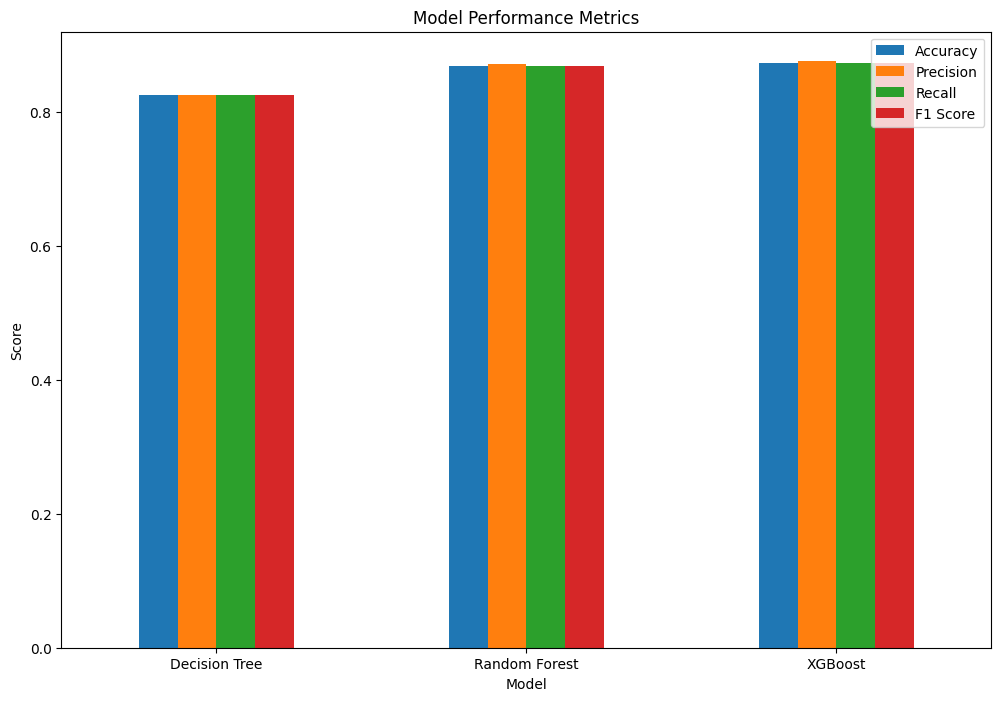

,Feature,imp_dtc,rank_dtc,imp_rfc,rank_rfc,imp_xgb,rank_xgb
0,blog_cartola,0.545268,1,0.361599,1,0.502237,1
1,idade,0.057203,2,0.059227,2,0.033774,4
2,tempo_total,0.046971,3,0.050036,4,0.009822,14
3,futebol,0.040007,4,0.053128,3,0.017007,5
4,home,0.033161,5,0.037178,8,0.010114,12
5,pviews,0.025016,6,0.038990,6,0.007622,27
6,futebol_olimpico,0.021870,7,0.030689,10,0.010730,10
7,dias,0.020412,8,0.039800,5,0.012637,8
8,device_pc_only,0.020250,9,0.038908,7,0.076395,2
9,home_olimpiadas,0.018449,10,0.028627,11,0.010683,11


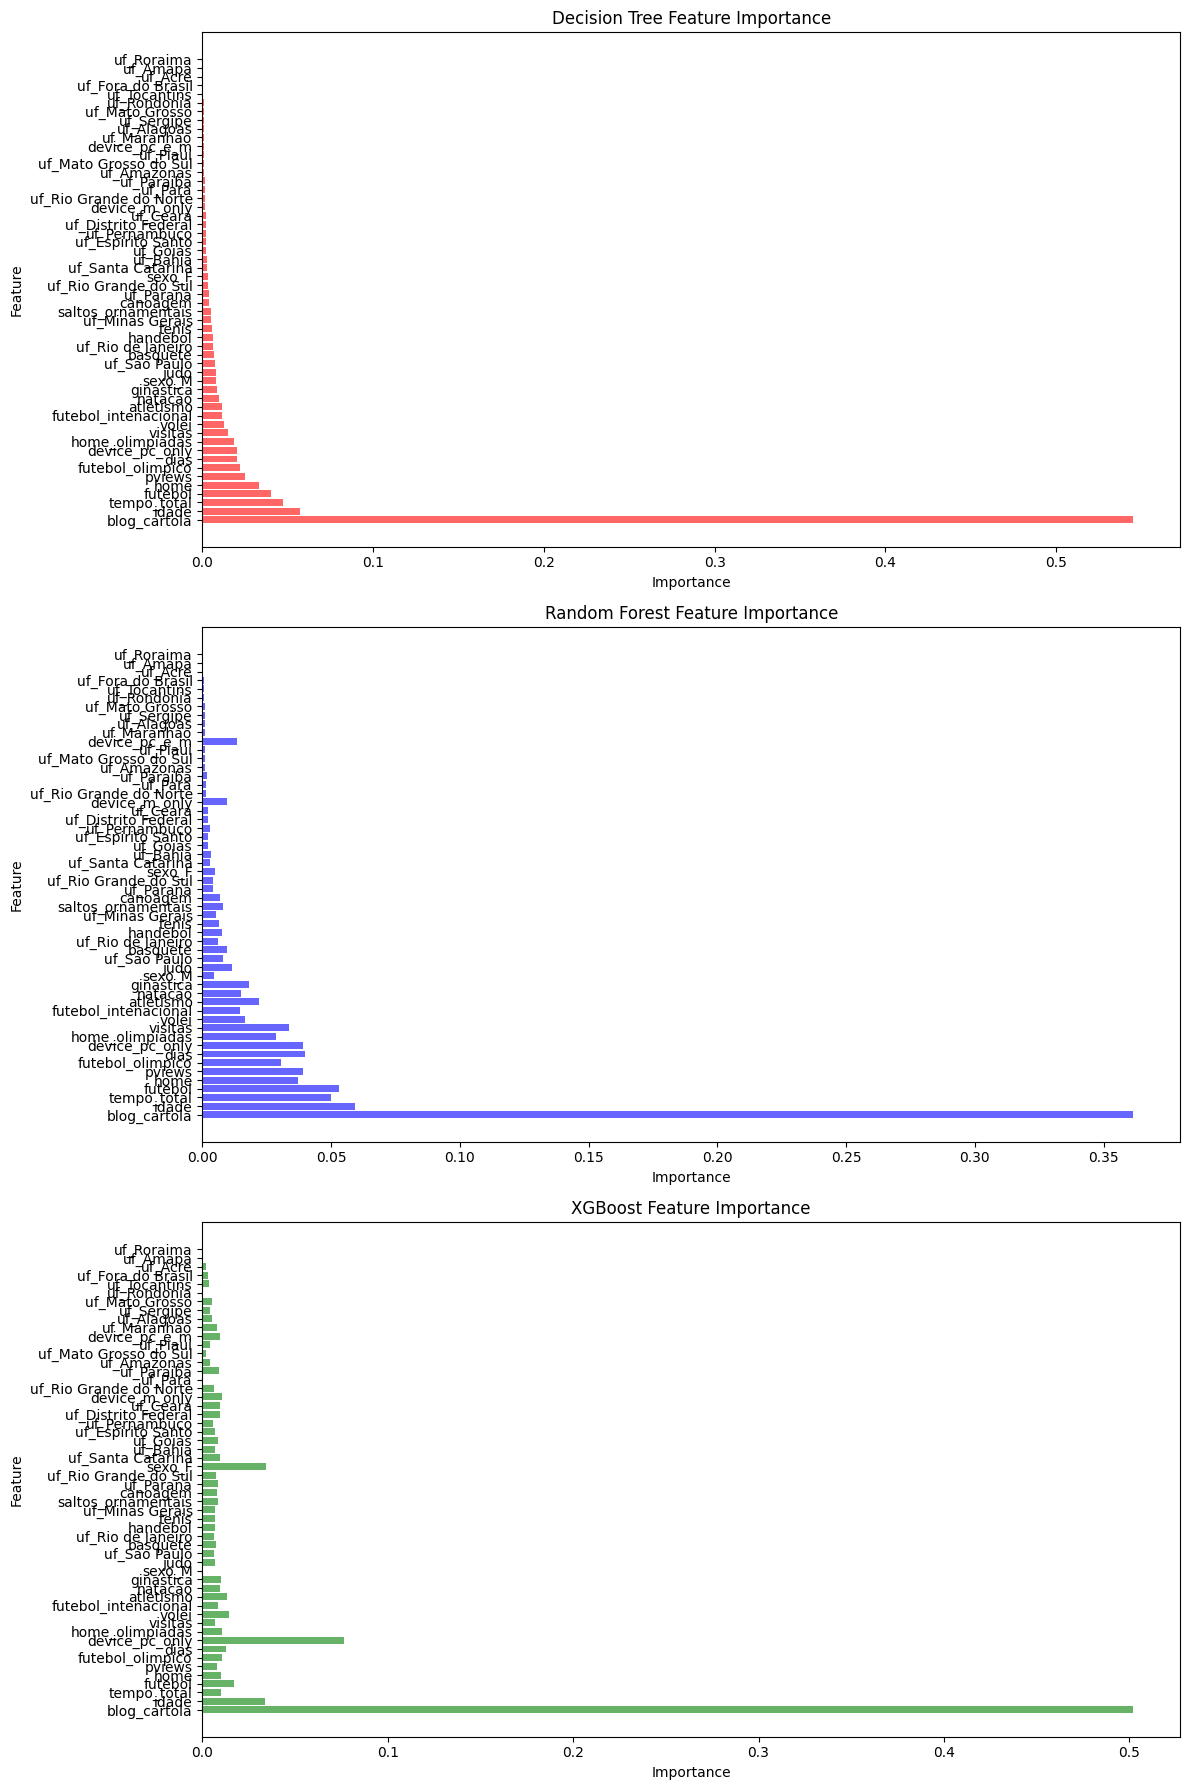

In [ ]:
# Importações necessárias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Definir a seed para reprodutibilidade
seed = 42
np.random.seed(seed)

# Configurações básicas
df_l2 = data_ml.copy()

# Passo 1 e 2: Filtrar o DataFrame para excluir "Não Pro" e transformar o problema em binário
df_filtered = df_l2[df_l2['cartola_status'].isin(['Cartola Free', 'Não Cartola'])]
df_filtered['is_cartola'] = df_filtered['cartola_status'].apply(lambda x: 1 if x == 'Cartola Free' else 0)

# Definindo X, y e tipos de colunas
numerical_cols = ['idade', 'dias', 'pviews', 'visitas', 'tempo_total', 'futebol',
                  'futebol_intenacional', 'futebol_olimpico', 'blog_cartola', 'atletismo',
                  'ginastica', 'judo', 'natacao', 'basquete',
                  'handebol', 'volei', 'tenis', 'canoagem',
                  'saltos_ornamentais', 'home', 'home_olimpiadas']
categorical_cols = ['sexo', 'uf', 'device']
dependent_col = ['is_cartola']
independent_col = numerical_cols + categorical_cols
all_cols = numerical_cols + categorical_cols + dependent_col

# Passo 3: Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_filtered[independent_col], df_filtered[dependent_col],
                                                    stratify=df_filtered[dependent_col], test_size=0.2, random_state=seed)

# Pré-processador para colunas numéricas e categóricas
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_cols),
                                               ('cat', OneHotEncoder(), categorical_cols)])

# Transformar os dados
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Converter os dados transformados de volta para DataFrame
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Inicializando e treinando os modelos
dt_model = DecisionTreeClassifier(random_state=seed)
rf_model = RandomForestClassifier(random_state=seed)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed)

dt_model.fit(X_train_transformed_df, y_train.values.ravel())
rf_model.fit(X_train_transformed_df, y_train.values.ravel())
xgb_model.fit(X_train_transformed_df, y_train.values.ravel())

# Avaliando cada modelo individualmente e obtendo as métricas
dt_metrics = evaluate_model(dt_model, X_train_transformed_df, X_test_transformed_df, y_train.values.ravel(), y_test.values.ravel(), "Decision Tree")
rf_metrics = evaluate_model(rf_model, X_train_transformed_df, X_test_transformed_df, y_train.values.ravel(), y_test.values.ravel(), "Random Forest")
xgb_metrics = evaluate_model(xgb_model, X_train_transformed_df, X_test_transformed_df, y_train.values.ravel(), y_test.values.ravel(), "XGBoost")

# Coletando todas as métricas em um DataFrame
metrics_df = pd.DataFrame([dt_metrics, rf_metrics, xgb_metrics])
print(metrics_df)

# Gráfico com as métricas
plot_model_metrics(metrics_df)

# Obter importâncias das features dos modelos já treinados
dt_fi = get_feature_importance(dt_model, X_train_transformed_df)
rf_fi = get_feature_importance(rf_model, X_train_transformed_df)
xgb_fi = get_feature_importance(xgb_model, X_train_transformed_df)

# Renomear as colunas para mesclagem
dt_fi = dt_fi.rename(columns={'Importance': 'imp_dtc', 'Rank': 'rank_dtc'})
rf_fi = rf_fi.rename(columns={'Importance': 'imp_rfc', 'Rank': 'rank_rfc'})
xgb_fi = xgb_fi.rename(columns={'Importance': 'imp_xgb', 'Rank': 'rank_xgb'})

# Mesclar os DataFrames de importância das features
merged_df = dt_fi.merge(rf_fi, on='Feature', how='left')\
                 .merge(xgb_fi, on='Feature', how='left')

display(merged_df)

# Plotando a importância das features
plot_feature_importance(merged_df)

## Valores de referência

Calcular os valores de referência para selecionar os usuários do grupo Não Cartola que tenham comportamentos semelhantes ao Cartola Free nas features de interesse.

In [ ]:
# Calculando Q1 (primeiro quartil) para Cartola Free

cartola_free = data[data['cartola_status'] == 'Cartola Free']
cortes_2 = ['tempo_total', 'blog_cartola', 'futebol', 'dias', 'idade', 'pviews']
cartola_free_cortes = cartola_free[cortes_2]

q1_free = cartola_free_cortes.quantile(0.25)

print(q1_free)

tempo_total     225.50425
blog_cartola     45.00000
futebol           0.00000
dias              2.00000
idade            26.00000
pviews            5.00000
Name: 0.25, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Aplicar o corte nos dados do Cartola Free

nao_cartola = data[data['cartola_status'] == 'Não Cartola']

cont_base_n_cartola = nao_cartola[
    (nao_cartola['tempo_total'] >= q1_free['tempo_total']) &
    # (nao_cartola['blog_cartola'] >= q1_free['blog_cartola']) &
    (nao_cartola['pviews'] >= q1_free['pviews']) &
    (nao_cartola['futebol'] >= q1_free['futebol']) &
    (nao_cartola['dias'] >= q1_free['dias']) &
    (nao_cartola['idade'] >= q1_free['idade'])
]

tot_base_n_cartola = nao_cartola.shape[0]
tot_base_n_cartola_corte = cont_base_n_cartola.shape[0]
perc_n_cartola = (tot_base_n_cartola_corte / tot_base_n_cartola)*100

print(f'''Percentual da base de Não Cartola selecionado: {round(perc_n_cartola,2)}
      Amostra Não Cartola: {tot_base_n_cartola}
      Usuários Selecionados: {tot_base_n_cartola_corte}
      ''')

Percentual da base de Não Cartola selecionado: 55.86
      Amostra Não Cartola: 20434
      Usuários Selecionados: 11415
      


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

